In [1]:
### already did regrid, so now open to reuse
import torch
import xesmf as xe
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

/work/albertl_uri_edu/.conda/envs/f2f_2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.weight'] = "bold"
plt.rcParams['legend.framealpha'] = 0

x = xr.open_dataset('../data/GLDAS/GLDAS_NOAH025_M.A200207.021.nc4')
x1 = xr.open_dataset('../data/MODIS/AQUA_MODIS.20020701_20020731.L3m.MO.NSST.sst.9km.nc')
weights = xr.open_dataset('../data/bilinear_600x1440_2160x4320.nc')
Qs_GLDAS = x.Qs_acc
Qsb_GLDAS = x.Qsb_acc
sst = x1.sst
regrid = xe.Regridder(Qs_GLDAS,sst,method='bilinear',weights=weights)

def replace_nan(z,val):
    z = np.where(z==val,np.nan,z)
    return z

def foldit(x,og):
    x0 = x.reshape(-1,1,x.shape[2]*x.shape[3]).permute(1,2,0)
    fold = torch.nn.Fold(output_size=(og.shape[2],og.shape[3]),kernel_size=(patchsize,patchsize),stride=(patchsize,patchsize))
    return fold(x0)

Qs_GLDAS_rg = regrid(Qs_GLDAS)
Qsb_GLDAS_rg = regrid(Qsb_GLDAS)
Qs = replace_nan(Qs_GLDAS_rg,0)
Qsb = replace_nan(Qsb_GLDAS_rg,0)
vmin = 0
vmax = 1
cmap = mpl.colormaps['cividis']



/work/albertl_uri_edu/.conda/envs/f2f_2/lib/python3.10/site-packages/xarray/core/dataarray.py:853: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


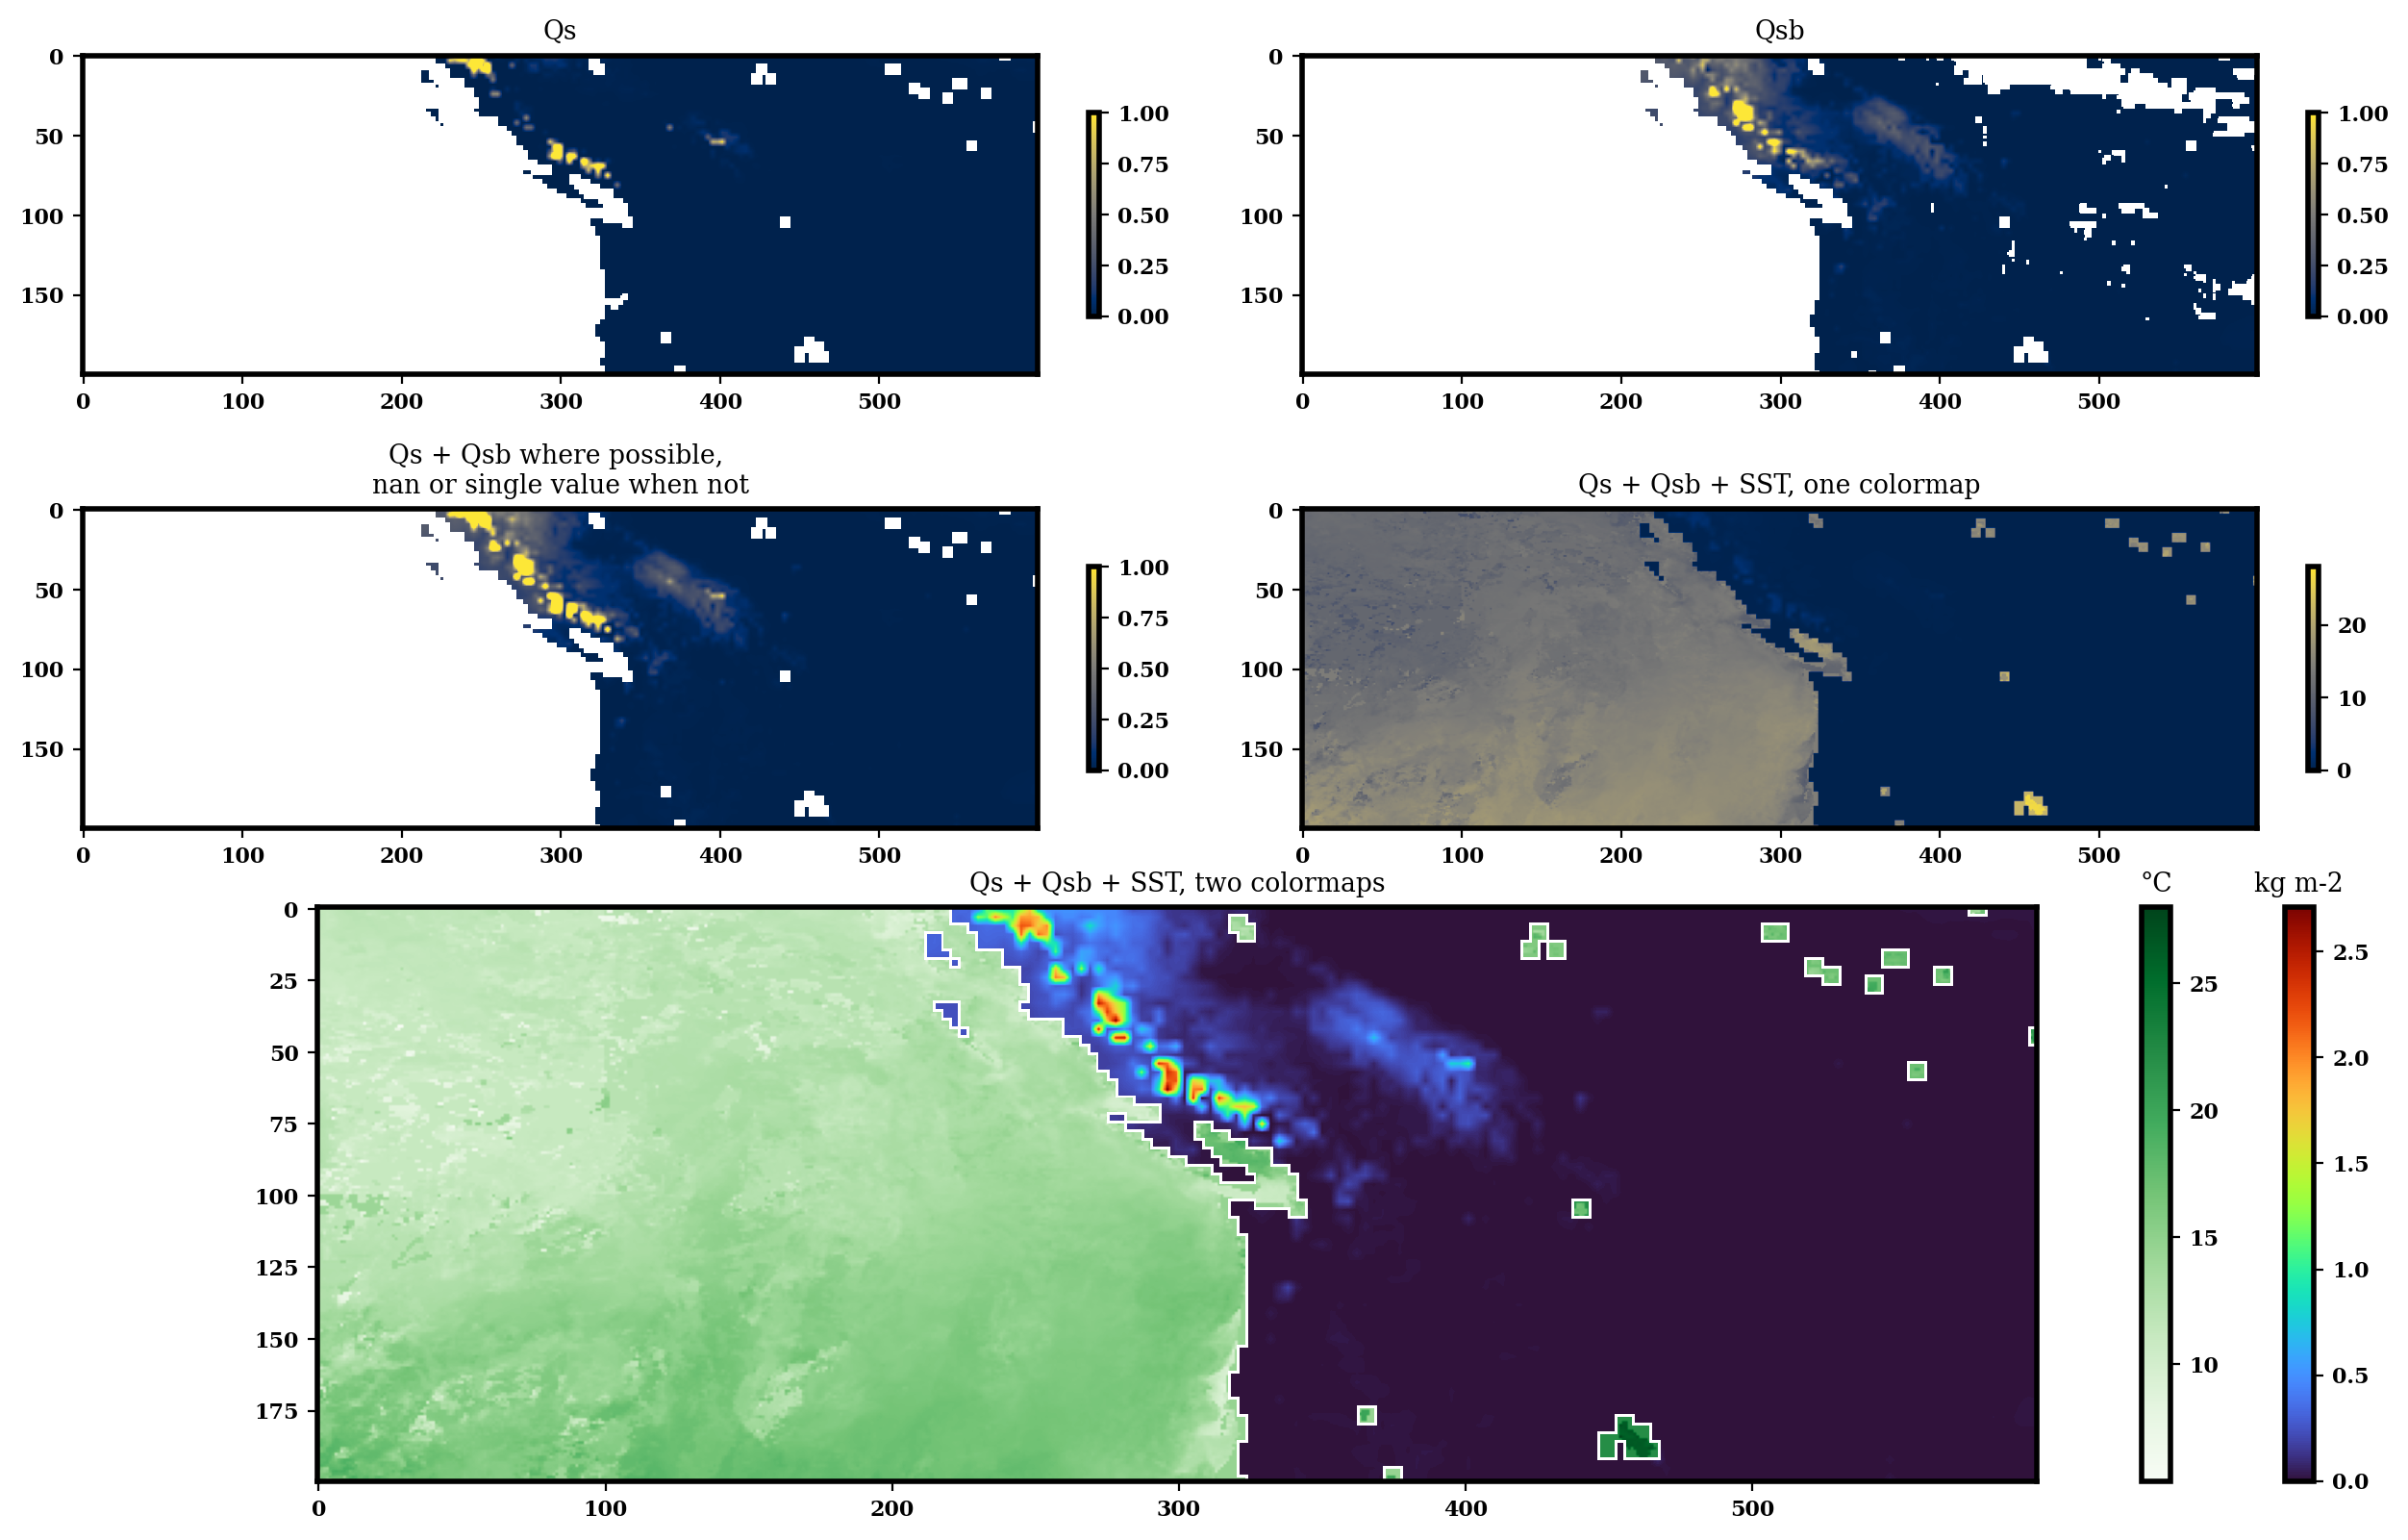

In [15]:
loc_up = 400
loc_down = 600
loc_left = 1350
loc_right = 1950


a1 = np.roll(Qs[0],1000)
a2 = np.roll(Qsb[0],1000)
a1_bool = np.where(np.isnan(a1) == True, 1, 0)
a2_bool = np.where(np.isnan(a2) == True, 1, 0)
a1_0 = np.where(np.isnan(a1) == True, 0, a1)
a2_0 = np.where(np.isnan(a2) == True, 0, a2)
a3_0 = a1_0 + a2_0
a3_bool = np.where((a1_bool == 0) | (a2_bool == 0),a3_0,np.nan)
a1 = a1[loc_up:loc_down,loc_left:loc_right]
a2 = a2[loc_up:loc_down,loc_left:loc_right]
a3 = a3_bool[loc_up:loc_down,loc_left:loc_right]
a4 = np.roll(sst,1000)
a4 = a4[loc_up:loc_down,loc_left:loc_right]
A4 = torch.from_numpy(a4).unsqueeze(0).unsqueeze(0)
patchsize = 100
unfoldobj = torch.nn.Unfold(kernel_size = (patchsize,patchsize),stride=int((patchsize/1)))
mask_patches = unfoldobj(A4).permute(2,0,1).reshape(-1,1,patchsize,patchsize)
d = [torch.where(torch.isfinite(x) == True, x, torch.nanmean(x)) for x in mask_patches]
for idx,x in enumerate(d):
    if idx == 0:
        e = x
    else:
        e = torch.cat((e,x))
e = e.unsqueeze(1)
ya = foldit(e,A4)
ya = np.where(np.isfinite(ya) == False, np.nanmean(ya),ya)

xxxx = np.where(np.isfinite(a3) == True, a3, ya[0,0])


fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(nrows=3,ncols=1,hspace=.05,wspace=.3,width_ratios=[1],height_ratios=[.3,.3,.4])
sub0 = gs[0].subgridspec(1,2)
sub1 = gs[1].subgridspec(1,2)

fig.add_subplot(sub0[0])
plt.imshow(a1,
           vmin=vmin,
           vmax=vmax,
          cmap=cmap)
plt.title('Qs')
plt.colorbar(fraction=.01)

fig.add_subplot(sub0[1])

plt.imshow(a2,
           vmin=vmin,
           vmax=vmax,
          cmap=cmap)
plt.title('Qsb')
plt.colorbar(fraction=.01)

fig.add_subplot(sub1[0])
plt.imshow(a3,
           vmin=vmin,
           vmax=vmax,
          cmap=cmap)
plt.title('Qs + Qsb where possible, \nnan or single value when not')
plt.colorbar(fraction=.01)

fig.add_subplot(sub1[1])
plt.imshow(xxxx,cmap = cmap)
plt.title('Qs + Qsb + SST, one colormap')
plt.colorbar(fraction=.01)


fig.add_subplot(gs[2])
plt.imshow(np.where(np.isnan(a3) == False, a3,np.nan),cmap='turbo')
plt.title('Qs + Qsb + SST, two colormaps')
plt.gca().set_aspect('equal')
clb = plt.colorbar(fraction=.015,location='right')
clb.ax.set_title('kg m-2')
plt.imshow(np.where(np.isnan(a3) == True, xxxx, np.nan),cmap='Greens')
clb = plt.colorbar(fraction=.015,location='right')
clb.ax.set_title('°C');